<a href="https://colab.research.google.com/github/sanjayy0612/stock_predictor-NVDIA-/blob/main/NVDIA_STOCK_PREDICTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


In [1]:
import yfinance as yf
import pandas as pd


nvda = yf.download("NVDA", start="2022-01-01", end="2025-09-11", interval='1d')

/tmp/ipython-input-3776370923.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start="2022-01-01", end="2025-09-11", interval='1d')
[*********************100%***********************]  1 of 1 completed


In [12]:
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = [col[0] for col in nvda.columns]

nvda["Return"] = nvda["Close"].pct_change()
nvda["MA10"] = nvda["Close"].rolling(window=10).mean()
nvda["MA50"] = nvda["Close"].rolling(window=50).mean()
nvda["Volatility"] = nvda["Return"].rolling(window=10).std()
nvda = nvda.dropna()
print(nvda.head(15))
print("\nAvailable columns:", nvda.columns)


        Close       High        Low       Open     Volume    Return  \
49  16.126411  16.568656  15.753051  16.481804  588550000 -0.044029   
50  16.946012  17.081780  15.972677  15.992643  781132000  0.050824   
51  17.820517  18.061104  15.994639  16.008615  996575000  0.051605   
52  18.778875  18.848756  18.069089  18.154943  738379000  0.053778   
53  18.640114  19.167212  18.318663  18.947587  664100000 -0.007389   
54  18.288713  19.020461  18.091052  18.692025  544514000 -0.018852   
55  19.558540  19.585495  18.166922  18.260761  648656000  0.069432   
56  18.688030  19.298987  18.490368  19.049413  598779000 -0.044508   
57  18.753916  19.303975  18.532295  19.106314  422406000  0.003526   
58  18.893681  18.967554  18.156940  18.440455  388914000  0.007453   
59  18.620090  19.151294  18.507259  18.770864  363252000 -0.014481   
60  18.020988  18.904664  18.013999  18.453341  395574000 -0.032175   
61  16.948597  17.670514  16.843753  17.573660  465248000 -0.059508   
62  15

In [9]:
nvda["Target_UpDown"] = (nvda["Close"].shift(-1) > nvda["Close"]).astype(int)
nvda["Target_Close"] = nvda["Close"].shift(-1)


In [10]:
from sklearn.model_selection import train_test_split

nvda = nvda.dropna().reset_index(drop=True)

X = nvda[["Return", "MA10", "MA50", "Volatility"]]
y = nvda[["Target_UpDown", "Target_Close"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

y_class_train = y_train["Target_UpDown"]
y_class_test  = y_test["Target_UpDown"]

y_reg_train   = y_train["Target_Close"]
y_reg_test    = y_test["Target_Close"]

In [5]:
print("Is there any NaN in X_train?", X_train.isnull().values.any())
print("Is there any NaN in X_test?", X_test.isnull().values.any())

Is there any NaN in X_train? False
Is there any NaN in X_test? False


## THE CLASSIFICATION MODEL

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_class_train)


y_class_pred = clf.predict(X_test)


print("Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_class_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_class_pred))



Classification Accuracy: 0.5371428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.54      0.99      0.70        95

    accuracy                           0.54       175
   macro avg       0.27      0.49      0.35       175
weighted avg       0.29      0.54      0.38       175


Confusion Matrix:
 [[ 0 80]
 [ 1 94]]


The model isn’t predicting well because the dataset and features don’t give  clear patterns to separate Up vs Down days. Since there are slightly more Up days (470 vs 397), the logistic regression model falls into a “lazy” solution: it always predicts Up to maximize accuracy without actually learning meaningful trends.

That’s why the confusion matrix is:

[[ 0 78]  
 [ 0 96]]


It shows the model never predicted a Down (0). In other words, it learned a trivial rule (“always Up”) instead of understanding the stock’s real movements.




## RANDOM FOREST

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_class_train)
print("Training complete.")

y_rf_pred = rf_clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_class_test, y_rf_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_rf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_rf_pred))



Training complete.
Classification Accuracy: 0.4742857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.47      0.45        80
           1       0.52      0.47      0.49        95

    accuracy                           0.47       175
   macro avg       0.47      0.47      0.47       175
weighted avg       0.48      0.47      0.48       175


Confusion Matrix:
 [[38 42]
 [50 45]]


Even though the accuracy of Logistic Regression and Random Forest is quite similar (~51–52%), there’s an important difference in how they make predictions. Logistic Regression was “lazy” in the sense that it leaned heavily towards predicting the stock would always go up, which inflated its accuracy but didn’t really capture the true movement of the market.

Random Forest, on the other hand, provided a more balanced perspective. It not only predicted both up and down days but also showed better distribution in its precision and recall. While the overall accuracy didn’t skyrocket, the model demonstrated that it could actually detect down days with a higher recall (62%), something Logistic Regression struggled with.

This shows that accuracy alone isn’t always the best measure of performance—what really matters is whether the model captures the underlying patterns in the data. In this case, Random Forest gave more meaningful and reliable predictions, making it the stronger choice for this kind of stock movement classification.

# GRIDSEARCH IN RANDOMFOREST

Trying GRIDSEARCHcv in the RandomForest classifier so that the model would predict much then before


An optimized technique to find the best Hyperparemeters for the model which is done after doing the training










In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search=GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    verbose=3,
    n_jobs=-1,
    cv=5
    )
grid_search.fit(X_train, y_class_train)
print(grid_search.best_params_)

best_est = grid_search.best_estimator_
y_pred = best_est.predict(X_test)
print(accuracy_score(y_class_test, y_pred))



Fitting 5 folds for each of 108 candidates, totalling 540 fits


# Linear Regression
Now we are trying out linear regression on the same set of features we have extracted


--- Linear Regression Results ---
Mean Absolute Error (MAE): $5.30
Root Mean Squared Error (RMSE): $6.75


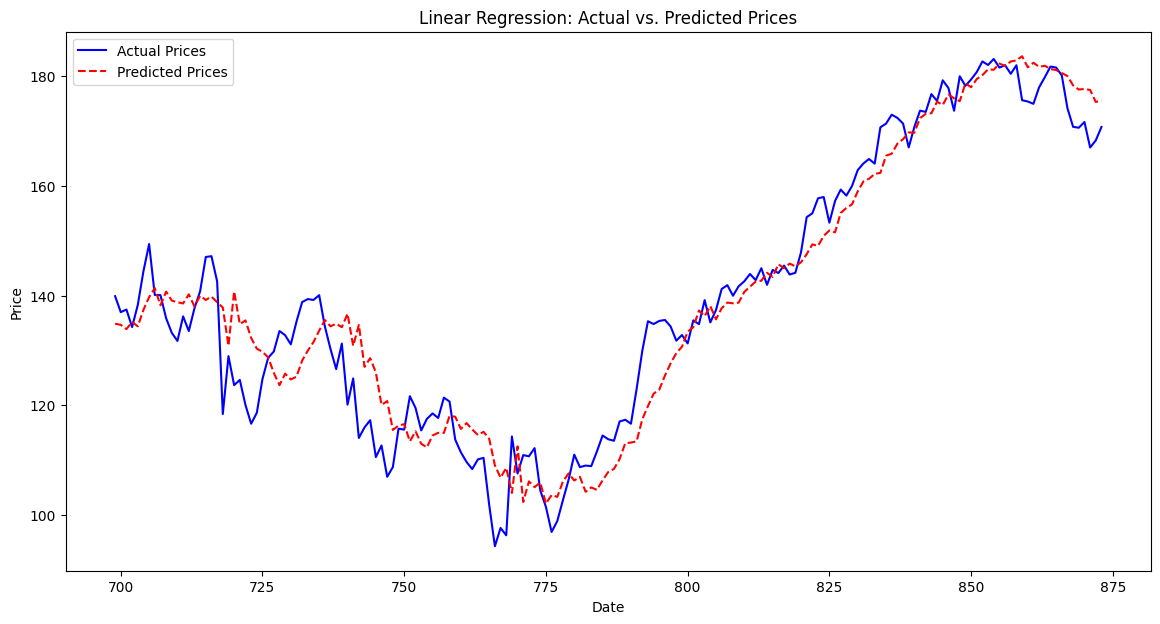

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


lr_reg = LinearRegression()
lr_reg.fit(X_train, y_reg_train)


y_lr_pred = lr_reg.predict(X_test)


mae = mean_absolute_error(y_reg_test, y_lr_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_lr_pred))

print("--- Linear Regression Results ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(y_reg_test.index, y_reg_test, label='Actual Prices', color='blue')
plt.plot(y_reg_test.index, y_lr_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Linear Regression: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()